In [83]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint
from scipy.stats import normaltest

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from typing import Dict

from copy import deepcopy

pd.options.mode.chained_assignment = None

In [84]:
import warnings

def _warn(*argv, **kwargs):
    pass

warnings.warn = _warn

In [85]:
df = pd.read_excel("/content/drive/MyDrive/dataset/employee_burnout_analysis-AI 2.xlsx")

In [86]:
print(df.head())

                Employee_ID Date_of_Joining  Gender Company_Type  \
0  fffe32003000360033003200      2008-09-30  Female      Service   
1      fffe3700360033003500      2008-11-30    Male      Service   
2  fffe31003300320037003900      2008-03-10  Female      Product   
3  fffe32003400380032003900      2008-11-03    Male      Service   
4  fffe31003900340031003600      2008-07-24  Female      Service   

  WFH_Setup_Available  Designation  Resource_Allocation  Mental_Fatigue_Score  \
0                  No            2                  3.0                   3.8   
1                 Yes            1                  2.0                   5.0   
2                 Yes            2                  NaN                   5.8   
3                 Yes            1                  1.0                   2.6   
4                  No            3                  7.0                   6.9   

   Burn_Rate  
0       0.16  
1       0.36  
2       0.49  
3       0.20  
4       0.52  


In [87]:
print(df.isna().sum())

Employee_ID                0
Date_of_Joining            0
Gender                     0
Company_Type               0
WFH_Setup_Available        0
Designation                0
Resource_Allocation     1381
Mental_Fatigue_Score    2117
Burn_Rate               1124
dtype: int64


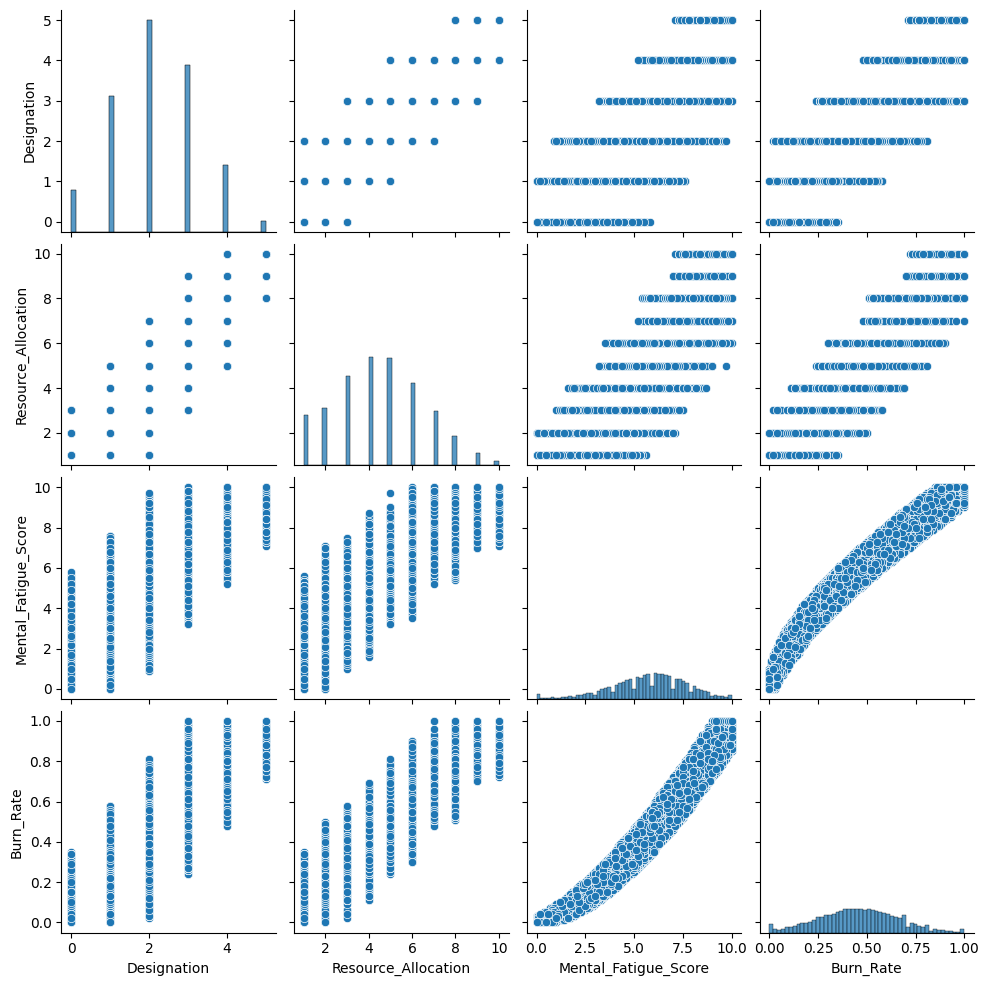

In [88]:
sns.pairplot(df)

In [89]:
df = df.dropna()
print(len(df))

18590


In [90]:
print(df.dtypes)

Employee_ID                     object
Date_of_Joining         datetime64[ns]
Gender                          object
Company_Type                    object
WFH_Setup_Available             object
Designation                      int64
Resource_Allocation            float64
Mental_Fatigue_Score           float64
Burn_Rate                      float64
dtype: object


In [91]:
df_obj = df.select_dtypes(object)
pprint({ c : df_obj[c].unique()[:10] for c in df_obj.columns})

{'Company_Type': array(['Service', 'Product'], dtype=object),
 'Employee_ID': array(['fffe32003000360033003200', 'fffe3700360033003500',
       'fffe32003400380032003900', 'fffe31003900340031003600',
       'fffe3300350037003500', 'fffe33003300340039003100',
       'fffe32003600320037003400', 'fffe33003100330032003700',
       'fffe3400310035003800', 'fffe33003100330036003300'], dtype=object),
 'Gender': array(['Female', 'Male'], dtype=object),
 'WFH_Setup_Available': array(['No', 'Yes'], dtype=object)}


In [92]:
df = df.drop("Employee_ID", axis=1)
print(df.head().T)

                                        0                    1  \
Date_of_Joining       2008-09-30 00:00:00  2008-11-30 00:00:00   
Gender                             Female                 Male   
Company_Type                      Service              Service   
WFH_Setup_Available                    No                  Yes   
Designation                             2                    1   
Resource_Allocation                   3.0                  2.0   
Mental_Fatigue_Score                  3.8                  5.0   
Burn_Rate                            0.16                 0.36   

                                        3                    4  \
Date_of_Joining       2008-11-03 00:00:00  2008-07-24 00:00:00   
Gender                               Male               Female   
Company_Type                      Service              Service   
WFH_Setup_Available                   Yes                   No   
Designation                             1                    3   
Resource_

Min date: 2008-01-01 00:00:00
Max date: 2008-12-31 00:00:00


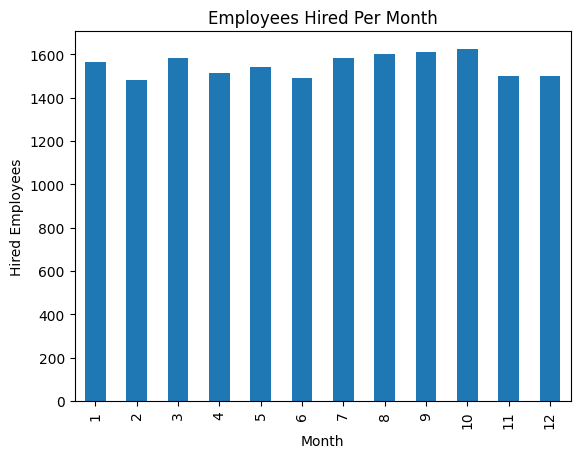

In [93]:
df["Date_of_Joining"] = pd.to_datetime(df["Date_of_Joining"], errors="coerce")

print(f"Min date: {df['Date_of_Joining'].min()}")
print(f"Max date: {df['Date_of_Joining'].max()}")

df_month = df.copy()
df_month["Month"] = df_month["Date_of_Joining"].dt.month
monthly_counts = df_month.groupby("Month")["Date_of_Joining"].count()

monthly_counts.plot(kind="bar")
plt.xlabel("Month")
plt.ylabel("Hired Employees")
plt.title("Employees Hired Per Month")
plt.show()

In [94]:
df["Date_of_Joining"] = pd.to_datetime(df["Date_of_Joining"], errors="coerce")
dt_2008 = pd.to_datetime("2008-01-01")
df["Days"] = (df["Date_of_Joining"] - dt_2008).dt.days
print(df["Days"])

0        273
1        334
3        307
4        205
5        330
        ... 
22743    349
22744    147
22746     18
22748      9
22749      5
Name: Days, Length: 18590, dtype: int64


In [95]:
numerical_features = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numerical_features].corr()
burn_rate_correlations = correlation_matrix["Burn_Rate"]
burn_rate_correlations = burn_rate_correlations[burn_rate_correlations.index != "Burn_Rate"]
print(burn_rate_correlations)

Designation             0.736412
Resource_Allocation     0.855005
Mental_Fatigue_Score    0.944389
Days                    0.000309
Name: Burn_Rate, dtype: float64


In [96]:
df = df.drop(["Date_of_Joining", "Days"], axis=1)
print(df.head().T)

                            0        1        3        4        5
Gender                 Female     Male     Male   Female     Male
Company_Type          Service  Service  Service  Service  Product
WFH_Setup_Available        No      Yes      Yes       No      Yes
Designation                 2        1        1        3        2
Resource_Allocation       3.0      2.0      1.0      7.0      4.0
Mental_Fatigue_Score      3.8      5.0      2.6      6.9      3.6
Burn_Rate                0.16     0.36      0.2     0.52     0.29


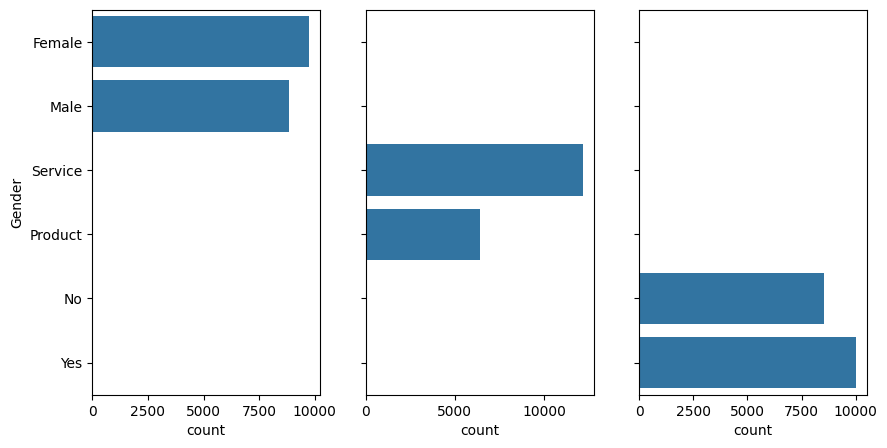

In [97]:
cat_columns = df.select_dtypes(object).columns
fig, ax = plt.subplots(nrows=1, ncols=len(cat_columns), sharey=True, figsize=(10,5))
for i, c in enumerate(cat_columns):
    sns.countplot(df[c], ax=ax[i])
plt.show()

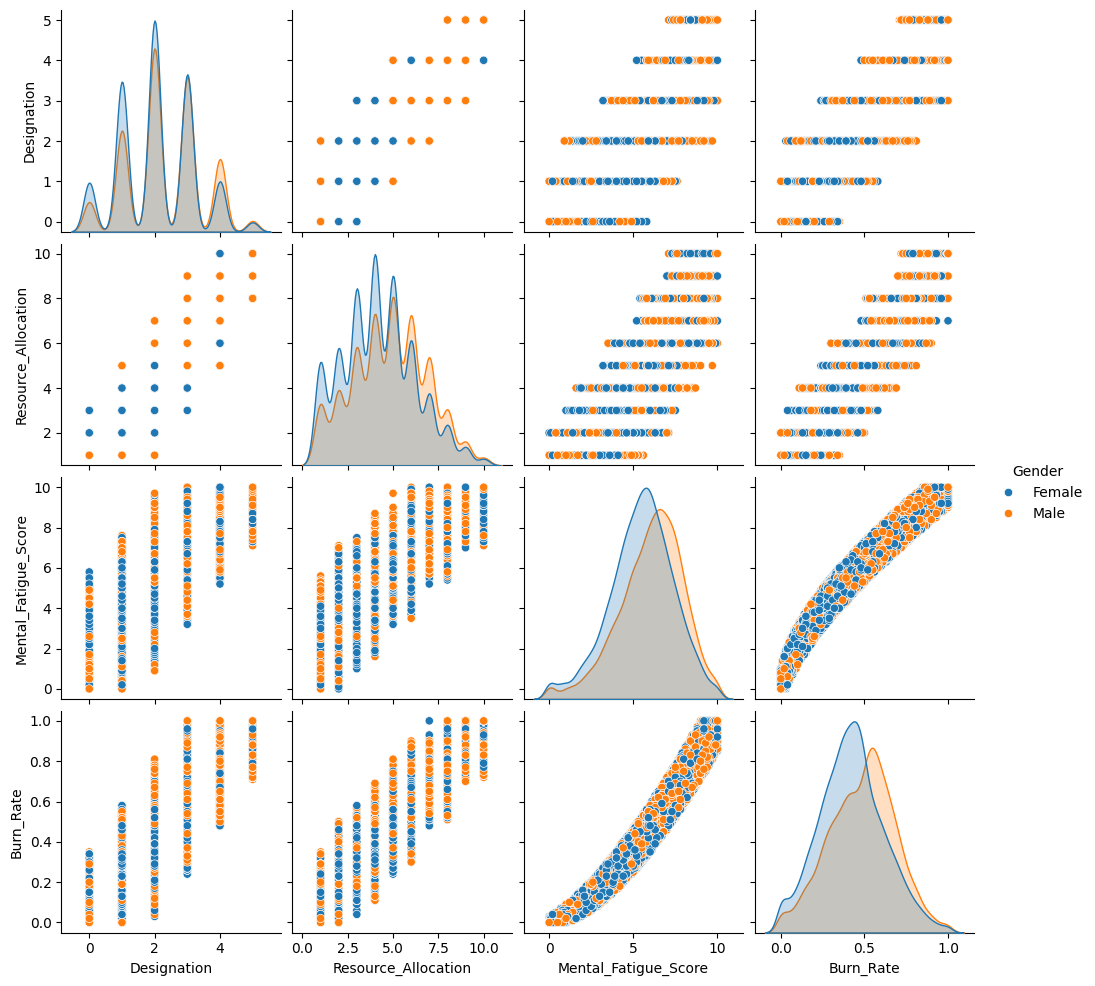

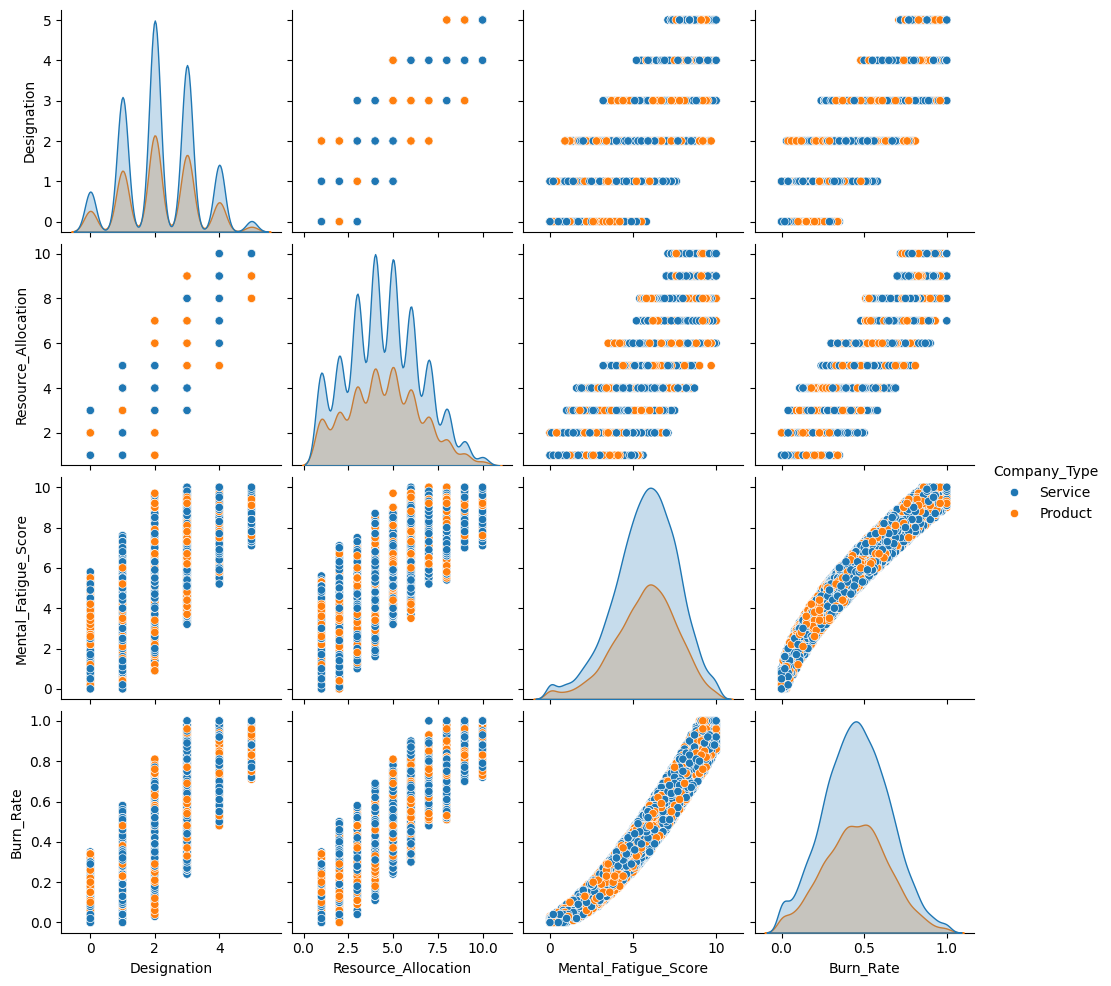

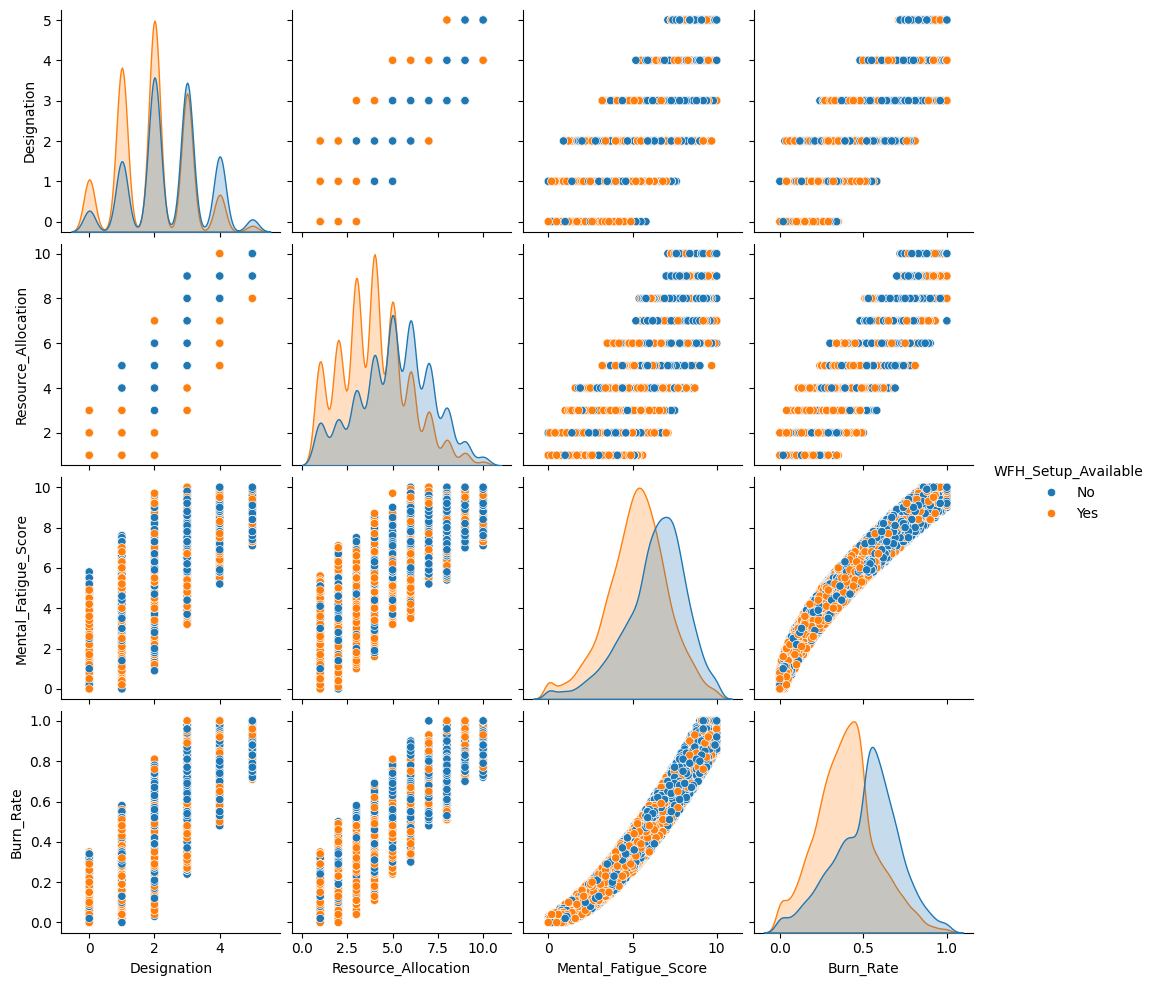

In [98]:
for c in df.select_dtypes(object).columns:
    sns.pairplot(df, hue=c)
plt.show()

In [99]:
for c in df.select_dtypes(exclude=object):
    print(f"{c}: (p-value = {normaltest(df[c])[1]})")

Designation: (p-value = 7.799535630459232e-52)
Resource_Allocation: (p-value = 9.214167946666707e-96)
Mental_Fatigue_Score: (p-value = 6.8137251483124435e-124)
Burn_Rate: (p-value = 1.0375928238178144e-16)


In [100]:
df = pd.get_dummies(df, columns=["Company_Type", "WFH_Setup_Available", "Gender"], drop_first=True)
print(df.head().T)

                             0     1     3      4      5
Designation                  2     1     1      3      2
Resource_Allocation        3.0   2.0   1.0    7.0    4.0
Mental_Fatigue_Score       3.8   5.0   2.6    6.9    3.6
Burn_Rate                 0.16  0.36   0.2   0.52   0.29
Company_Type_Service      True  True  True   True  False
WFH_Setup_Available_Yes  False  True  True  False   True
Gender_Male              False  True  True  False   True


In [101]:
y_col = 'Burn_Rate'
df.columns
X = df[[c for c in df.columns if c != y_col]]
y = df[y_col]

print(X.shape)
print(y.shape)

(18590, 6)
(18590,)


In [102]:
def create_pipeline(model_name: str, model_params: Dict):
    model = getattr(linear_model, model_name)()
    estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures()),
        ("scaler", StandardScaler()),
        (model_name, model)
    ])

    params = {'polynomial_features__degree': [1, 2]}
    params.update({model_name + "__" + k: v for k, v in model_params.items()})

    return estimator, params


In [103]:
results = {}
for name, params in {
    "LinearRegression": {},
    "Lasso": {"alpha": np.geomspace(0.0001, 0.001, 50)},
    "Ridge": {"alpha": np.geomspace(10, 15, 50)},
}.items():
    kf = KFold(n_splits=5, shuffle=True, random_state=123)
    estimator, params = create_pipeline(name, params)
    grid = GridSearchCV(estimator, params, cv=kf, scoring=make_scorer(r2_score), n_jobs=4)
    result = grid.fit(X, y)
    print(name)
    print("=" * len(name))
    print("Params:")
    pprint(result.best_params_)
    print(f"R2 score: {result.best_score_}")
    print()
    results[name] = result


LinearRegression
Params:
{'polynomial_features__degree': 2}
R2 score: 0.9242558063396764

Lasso
=====
Params:
{'Lasso__alpha': 0.00011513953993264469, 'polynomial_features__degree': 2}
R2 score: 0.9242902867272779

Ridge
=====
Params:
{'Ridge__alpha': 10.0, 'polynomial_features__degree': 2}
R2 score: 0.9242558282941047



In [104]:
estimator = deepcopy(results["Lasso"].best_estimator_)

estimator.fit(X, y)
print(r2_score(y, estimator.predict(X)))

0.924516995662191


In [105]:
df_coefs = pd.DataFrame()
for model_name, result in results.items():
    df_coefs[model_name+"_Coefficients"] = result.best_estimator_[-1].coef_

df_coefs_stats = df_coefs.describe()
df_coefs_stats.rename({'50%': 'median'}, inplace=True)
print(df_coefs_stats)

        LinearRegression_Coefficients  Lasso_Coefficients  Ridge_Coefficients
count                       28.000000           28.000000           28.000000
mean                         0.007020            0.006955            0.006989
std                          0.024772            0.022539            0.022976
min                         -0.035259           -0.002382           -0.016258
25%                         -0.001042           -0.000168           -0.000935
median                       0.000428           -0.000000            0.000296
75%                          0.002389            0.000843            0.001890
max                          0.113684            0.113364            0.112173


In [106]:
estimator = results["Lasso"]
coefs = estimator.best_estimator_[-1].coef_
pf_names = estimator.best_estimator_[0].get_feature_names_out(X.columns)
pf_names = [col.replace(" ", " * ") for col in pf_names]

print("Total Coefficients: ", len(coefs))
print("Number of zero-value coefficients: ", (coefs==0).sum())

Total Coefficients:  28
Number of zero-value coefficients:  11


In [107]:
df_coefs = pd.DataFrame(coefs).T
df_coefs.columns = pf_names
sorted_coefs = df_coefs.T.sort_values(0, ascending=False)
print(sorted_coefs)

                                                       0
Mental_Fatigue_Score                            0.113364
Resource_Allocation                             0.030879
Mental_Fatigue_Score^2                          0.030052
Resource_Allocation^2                           0.016243
Resource_Allocation * Mental_Fatigue_Score      0.009086
Company_Type_Service * Gender_Male              0.001660
Gender_Male                                     0.001080
Mental_Fatigue_Score * Gender_Male              0.000765
Gender_Male^2                                   0.000008
Designation * Mental_Fatigue_Score             -0.000000
Resource_Allocation * Gender_Male               0.000000
WFH_Setup_Available_Yes * Gender_Male           0.000000
Company_Type_Service                            0.000000
Company_Type_Service * WFH_Setup_Available_Yes  0.000000
Company_Type_Service^2                          0.000000
Mental_Fatigue_Score * Company_Type_Service     0.000000
Designation^2                  